In [1]:
import numpy as np
import matplotlib.pyplot as pt
import scipy as ci
import pandas as pd
import seaborn as sns
import week06_solarsystemObject as SSO
%matplotlib inline

<font size=5>Problem 1<font>


Now instantiating the solar system.
planetary configuration for U.S. Central Time  Thu Mar 31 19:00:00 2016
cumulative position error was  13.7128118599  for  1423253  steps

perihelion coordinates, pass 2
 x, y 46000850887.9 11429816.5973
vx, vy -14.6548431067 58980.3649374
r, t (days) 46000852307.9 87.9896347276

perihelion coordinates, pass 3
 x, y 46000850887.9 11429795.5973
vx, vy -14.6548207756 58980.3649374
r, t (days) 46000852307.9 87.9896347234
precession angle (microradians):  248.469216145
total running time (seconds):  202.3961501121521


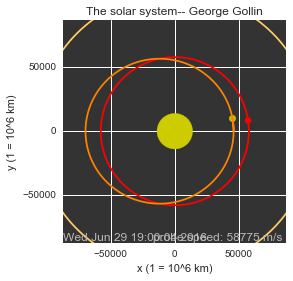

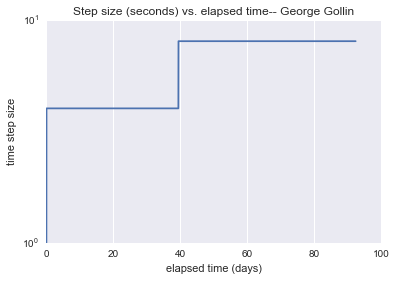

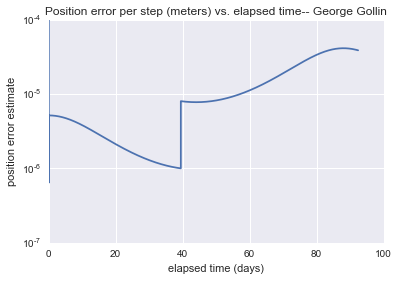

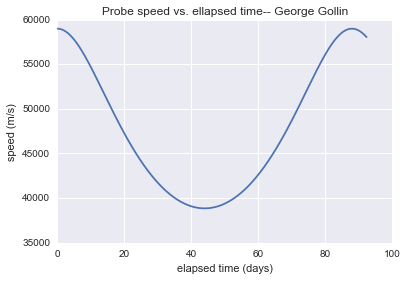

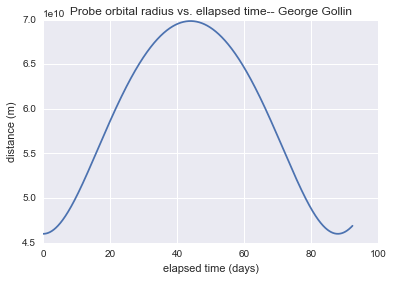

In [5]:
# Turn Off GR correction, and restoring mass of Jupiter 

###################################################################
# This file is week08_mercury.py. We will use it to study the physics behind
# the precession of Mercury's perihelion.
# Mercury's orbit parameters:
#   r = 46,001,200 km at perihelion
#   r = 69,816,900 km at aphelion
#   eccentricity = 0.205630
#   period = 87.969 days
#   AVERAGE orbital speed = 47.362 km/sec
# see also http://nssdc.gsfc.nasa.gov/planetary/factsheet/mercuryfact.html
# for slightly less precise data:
#   speed at perihelion: 58.98 km/sec
#   speed at aphelion: 38.86 km/sec
# see http://arxiv.org/abs/1106.1568v1: "When eﬀective theories predict: the 
# inevitability of Mercury’s anomalous perihelion precession"
# James D. Wells, CERN Theoretical Physics (PH-TH), CH-1211 Geneva 23, 
# Switzerland & Department of Physics, University of Michigan, Ann Arbor, MI 48109
# June 9, 2011.
# even more useful is the wikipedia article
# https://en.wikipedia.org/wiki/Two-body_problem_in_general_relativity#Precession_of_elliptical_orbits 
# it gives me 0.50248 microradians per orbit, which compares nicely
# with the measured value of .5024 microradians per orbit.
# in the body of the code below, distances are in meters and times in seconds.
# George Gollin, University of Illinois, June 17, 2016
# import libraries
import week06_solarsystemObject as SSO
import numpy as np
import matplotlib.pyplot as plt 
import time
####################### define the integration engine  ########################
def integrator(xn, yn, vxn, vyn, tn, dt, MySolarSystem, \
include_post_newtonian = False, conversion = np.longdouble):
    # calculate the change in position and velocity of an obejct moving under the
    # influence of gravity in the solar system. Note that we must pass to this
    # function the solar system object created in the main program since it 
    # might have had its, for example, planetary masses altered. 
    # we also want to force conversion of the arguments as "longdoubles":
    # float128 rather than float64 variables to increase precision
    # calculate dxn, etc. Note the call to a class function that gives us
    # gravitational acceleration as a function of position with respect to the sun.
    # last argument is True to include post-Newtonian effects from the sun's gravity
    dxn = vxn * dt
    dyn = vyn * dt
    dvxn, dvyn = MySolarSystem.accel(xn, yn, tn, include_post_newtonian) * dt
    # update intermediate position, velocity, and time
    xn_half = xn + dxn / 2
    yn_half = yn + dyn / 2
    vxn_half = vxn + dvxn / 2
    vyn_half = vyn + dvyn / 2
    tn_half = tn + dt / 2
    # calculate improved dxn, etc. see the in-class material writeup.
    dxn_improved = vxn_half * dt
    dyn_improved = vyn_half * dt
    dvxn_improved, dvyn_improved = MySolarSystem.accel(xn_half, yn_half, \
    tn_half, include_post_newtonian) * dt
    # now update position and velocity.
    xn = xn + dxn_improved
    yn = yn + dyn_improved
    vxn = vxn + dvxn_improved
    vyn = vyn + dvyn_improved
    # time too...
    tn = tn + dt
    # now return these.
    
    return np.array([xn, yn, vxn, vyn, tn])
############################# end of integrator ###############################    
######################### main program starts here ############################
############# initialize stuff #############
# Let's place a space probe in Mercury's orbit around the sun to use the tools
# we have developed to study the effects on this probe's orbit of the planets
# in the solar system as well as the effects associated with general realtivity.
# Our coordinate system is heliocentric: the sun is at the origin. I pretend
# that all planets orbit in perfect circles in the same plane. The exception is
# Mercury, or more precisely the probe we put into Mercury's orbit.
# The x and y axes are defined with respect to the fixed stars. 
# take note of the time of day we begin running the program
begin_running_program_time = time.time()
   
# instantiate the solar system!
MySolarSystem = SSO.SolarSystem()

###################################################################57909050.00e3
# turn off the gravitational influence of all the planets and the moon.
MySolarSystem.mass = np.array([1988550000.0e21, 0., 0., 0., 0., 1898600.00e21 , 0. , 0., \
0., 0., 0.]) ## Turn on Mass of Jupiter! 
###################################################################
# do we want to include the post-Newtonian (general relativistic) correction
# to the acceleration of gravity caused by the sun?
###################################################################
include_post_newtonian = False ## Turn if Off!! 
###################################################################

# mercury's perihelion and aphelion r values, meters:
mercury_perihelion_r = 46.001200000e9
mercury_aphelion_r = 69.816900000e9
# mercury's velocities at perihelion and aphelion, m/s:
mercury_perihelion_v = 58.98e3
mercury_aphelion_v = 38.86e3
# orbit eccentricity and period (seconds), in case I need them later
mercury_orbit_eccentricity = 0.205630
mercury_orbit_period_days = 87.969
mercury_orbit_period = mercury_orbit_period_days * 24 * 3600
# precession of perihelion from GR per orbit: get this from the 43 arcseconds
# per century rate. we will only use this to evaluate how well we are doing
precession_one_century = np.radians(43 / 3600)
# expected precession per orbit is about 5.024e-7 radians per orbit.
precession_one_orbit = precession_one_century * mercury_orbit_period_days / \
(365 * 100)
# spatial displacement of perihelion of orbit n+1 relative to perihelion of
# orbit n is about 23.1 km per orbit.
perihelion_movement_per_orbit = precession_one_orbit * mercury_perihelion_r
# start_time will be relevant for setting the positions of the other planets.
# t = zero is 4/1/16 00:00:00Z.
start_time = 0
# get the intial x,y positions for the Mercury probe. Put it on the x axis,
# at the perihelion.
xmercury_probe_now = mercury_perihelion_r
ymercury_probe_now = 0.
# get the intial x,y velocities for the Mercury probe. it is entirely in the
# y direction since we are at the perihelion.
vxmercury_probe_now = 0.
vymercury_probe_now = mercury_perihelion_v
# set the width of the plot to be fairly small.
MySolarSystem.plotwidth_mega_km = 2.5 * mercury_aphelion_r / 1.e9
# now initialize the probe's position using variables I employ inside the loop. 
# we need to make these extended precision quantities.
xprobe_now = np.longdouble(xmercury_probe_now)
yprobe_now = np.longdouble(ymercury_probe_now)
# set the initial velocity (m/s) too.
vxprobe_now = np.longdouble(vxmercury_probe_now)
vyprobe_now = np.longdouble(vymercury_probe_now)
# time interval between steps in our numerical integration, in seconds. I am
# using an adaptive method and will decrease or increase this as necessary.
mercury_probe_dt = 1
# dt for use inside our loop:
dt = np.longdouble(mercury_probe_dt)
# current time
time_now = np.longdouble(start_time)
# put Mercury at theta = 0 so we can use it to pace the probe.
MySolarSystem.theta0_degree[MySolarSystem.mercury_index] = 0.
MySolarSystem.theta0[MySolarSystem.mercury_index] = 0.
# maximum total length in days of our space flight
max_days_in_flight = 1.05 * mercury_orbit_period_days
# also calculate the maximum time in seconds.
max_elapsed_time_in_flight = max_days_in_flight * 24 * 3600
# we might not start at start_time = 0, which is April 1, 2016. Take this into
# account here. Time is in seconds.
flight_must_end_by_this_time = max_elapsed_time_in_flight + start_time
# rough estimate of number of steps to calculate: one more step than a specific 
# number of days of simulated flight would require if the step size never changed.
max_steps_float = max_days_in_flight * 24 * 3600 / mercury_probe_dt + 1 
# now turn this into an integer. round up using the ceil ("ceiling") function.
max_steps = int(np.ceil(max_steps_float))
# preallocate storage for arrays we will use; initilize them to "not a number" 
# (nan). this should save time over doing an append each time we want to add an 
# additional element onto the end of the array. we need to work to extended
# precision in our integration, so define them as longdoubles.
# xprobe, yprobe is probe position with respect to the sun.
xprobe = np.array([np.longdouble(np.nan)] * max_steps)
yprobe = np.array([np.longdouble(np.nan)] * max_steps)
# let's keep track of the probe's velocity with respect to the sun too.
vxprobe = np.array([np.longdouble(np.nan)] * max_steps)
vyprobe = np.array([np.longdouble(np.nan)] * max_steps)
# add a couple more arrays to help with (possibly changing) values of dt.
tprobe = np.array([np.longdouble(np.nan)] * max_steps)
dtprobe = np.array([np.longdouble(np.nan)] * max_steps)
# we don't want to draw an image of where the probe is every time we go through 
# the loop since that would slow us down too much. Let's limit the number of 
# images to one every few days.
time_per_image = 3 * 24 * 3600
image_drawing_ticker = -1
      
# loop index variable
index = 0
# we don't want to have a zillion figure windows open, so set the following flag
# to True.
close_previous_figure = True
# do we want to stop the loop when we land (or crash) into a planet? If not,
# the loop will pretend that all planets are point masses and go crazy.
stop_when_probe_lands = True
# let's adjust the time step based on the following estimated error thresholds,
# in meters 
# these values: runs in about 350 seconds, estimates the cumulative error as 
# 13.71 meters, gets the perihelion precession as .50248 microradians, closes the 
# orbit to within 14 meters when GR is off:
threshold_to_increase_dt = 0.000001
threshold_to_decrease_dt = 0.0001
# these values: runs in 101.3 seconds, closes classical orbit to within 181 meters,
# gives a precession of .4989 microradians
# threshold_to_increase_dt = 0.0001
# threshold_to_decrease_dt = 0.01
# these values: runs in 71.9 seconds, closes classical orbit to within 524 meters,
# gives a precession of .4915 microradians
# threshold_to_increase_dt = 0.001
# threshold_to_decrease_dt = 0.1
# how many passes through the loop since the last change in dt:    
passes_since_last_dt_change = 0
# cumulative error
cumulative_error = 0
# let's also keep track of the estimated error values for each step.
error_estimate_array = np.array([np.nan] * max_steps)
# initialize the error estimate to the upper limit threshold, just for grins.
error_estimate = threshold_to_decrease_dt
############# here's the loop #############
while (index < max_steps) and (time_now <= flight_must_end_by_this_time):
    
    # insert current position into the existing probe position arrays.
    xprobe[index] = xprobe_now
    yprobe[index] = yprobe_now
    
    # do the same for the probe's velocity.
    vxprobe[index] = vxprobe_now
    vyprobe[index] = vyprobe_now
    # also store time and dt in arrays.
    tprobe[index] = time_now
    dtprobe[index] = dt
    # store the estimated error we calculated for this point
    error_estimate_array[index] = error_estimate
    
    # update how many passes through the loop we've done since last
    # changing dt.
    passes_since_last_dt_change = passes_since_last_dt_change + 1
            
    # now check if I should decrease (or can increase) the time step. We need to
    # have at least three positions stored in the xprobe, etc. arrays since 
    # last changing dt to be able to calculate this.
    if passes_since_last_dt_change >= 3:
        
        # x error estimate for one step
        x_error_estimate = dt * np.abs(vxprobe[index] - 2 * vxprobe[index - 1] + \
        vxprobe[index - 2]) 
    
        # y error estimate for one step
        y_error_estimate = dt * np.abs(vyprobe[index] - 2 * vyprobe[index - 1] + \
        vyprobe[index - 2])  
        
        # add them in quadrature
        error_estimate = np.sqrt(x_error_estimate**2 + y_error_estimate**2)
        
        # also add into the cumulative error estimate.
        cumulative_error = cumulative_error + error_estimate
        
    # let's change the time step by a factor of 2 if we've crossed thresholds.
    # the integration method appears to change in precision by the cube of the 
    # step size.
        
    if error_estimate < threshold_to_increase_dt:
        dt = 2 * dt
        passes_since_last_dt_change = 0
        
        # also adjust the error estimate as the cube of the dt increase factor.
        error_estimate = error_estimate * 8
       
    elif error_estimate > threshold_to_decrease_dt:
        dt = dt / 2
        passes_since_last_dt_change = 0
        # also adjust the error estimate.
        error_estimate = error_estimate / 8
 
    # do I want to draw the solar system? Draw it the very first time
    # through, then at regular time intervals.
    # np.floor truncates: it turns 3.8 into 3.0, for example.
    image_number = int(np.floor((time_now - start_time) / time_per_image))
    draw_the_solar_system = image_number > image_drawing_ticker
    # now draw it if we want to.
    if draw_the_solar_system:
        # increment a counter relating to the number of images drawn so far        
        image_drawing_ticker = image_drawing_ticker + 1
        
        # figure out the probe's speed so we can put this number on the plot.
        speed_wrt_sun = np.sqrt(vxprobe_now**2 + vyprobe_now**2)   
            
        # now draw it.
        MySolarSystem.draw_solar_system(time_now, close_previous_figure, xprobe, \
        yprobe, speed_wrt_sun)
        
    # now update probe position and velocity using the higher order integration
    # technique from an earlier week. 
    
    xprobe_now, yprobe_now, vxprobe_now, vyprobe_now, time_now = \
    integrator(xprobe_now, yprobe_now, vxprobe_now, vyprobe_now, time_now, dt, \
    MySolarSystem, include_post_newtonian)    
    # update index 
    index = index + 1
    # end of loop. 
# we have filled various arrays with indices running from 0 to index - 1. But
# there might be a lot of unused elements in the arrays since we set the
# array lengths before we began adjusting the durations dt of intervals. 
# truncate arrays to get rid of the unused/unfilled elements.
xprobe = np.resize(xprobe, index)
yprobe = np.resize(yprobe, index)
vxprobe = np.resize(vxprobe, index)
vyprobe = np.resize(vyprobe, index)
tprobe = np.resize(tprobe, index)
dtprobe = np.resize(dtprobe, index)
error_estimate_array = np.resize(error_estimate_array, index)
# make an array that holds the speed of the probe too, so we can plot it.
speed_probe = np.sqrt(vxprobe**2 + vyprobe**2)
# also r for the probe...
r_probe = np.sqrt(xprobe**2 + yprobe**2)
# print information about cumulative error, etc.
print("cumulative position error was ", cumulative_error, " for ", index, " steps")
# now look for the low point at the end of the first orbit and hunt around for 
# the perihelion using a very fine-grained scan. Velocity at perihelion is
# about 59 km/s so we'll need to have a really small scanning interval, or
# else I'll need to do a fit rather than brute-forcing it. Let's start with
# a brute force approach.
# get the index of the lowest point in the orbit. Let's assume our integration
# runs over many many thousands of points so that it is safe to look for the 
# first local minimum after the first quarter of them.
cushion = int(np.size(r_probe)/4)
r_lowest = min(r_probe[cushion:])
# now get the index for this value. the "where" function returns a list of
# arrays of indices, for example (array([1375849]),). So we need to extract the
# first array, then extract its first element. Do all of that now.
index_list_of_arrays = np.where(r_probe[cushion:] == r_lowest)  # e.g. (array([1375849]),)
index_of_arrays = index_list_of_arrays[0]  # e.g. array([1375849])
index_of_r_lowest = index_of_arrays[0] + cushion
# start at the previous x, y and integrate up to the first one after the low
# point.
index_start = index_of_r_lowest - 1
xprobe_now = xprobe[index_start] 
yprobe_now = yprobe[index_start] 
vxprobe_now = vxprobe[index_start] 
vyprobe_now = vyprobe[index_start] 
time_now = tprobe[index_start]
rprobe_now = np.sqrt(xprobe_now**2 + yprobe_now**2)
# how large our step time needs to be depends on how fast we are moving and
# our desired level of precision.
desired_precision = 100.
probe_speed = np.sqrt(vxprobe_now**2 + vyprobe_now**2)
dt = desired_precision / probe_speed
number_of_steps = int((tprobe[index_of_r_lowest + 1] - time_now) / dt)
# keep track of a few points in our integration loop to home in further
# in a third pass.
xsave = np.array([np.longdouble(np.nan)] * number_of_steps)
ysave = np.array([np.longdouble(np.nan)] * number_of_steps)
vxsave = np.array([np.longdouble(np.nan)] * number_of_steps)
vysave = np.array([np.longdouble(np.nan)] * number_of_steps)
tsave = np.array([np.longdouble(np.nan)] * number_of_steps)
rsave = np.array([np.longdouble(np.nan)] * number_of_steps)
index = 0
rmin_so_far = 1.e12
index_min_so_far = 0
# now do our second-pass scan.
while index < number_of_steps:
    
    # store what we have so far
    xsave[index] = xprobe_now
    ysave[index] = yprobe_now
    vxsave[index] = vxprobe_now
    vysave[index] = vyprobe_now
    tsave[index] = time_now
    rsave[index] = rprobe_now
    
    if rprobe_now < rmin_so_far:
        rmin_so_far = rprobe_now
        index_min_so_far = index
    # now update probe position and velocity using the higher order integration
    # technique from an earlier week. 
    
    xprobe_now, yprobe_now, vxprobe_now, vyprobe_now, time_now = \
    integrator(xprobe_now, yprobe_now, vxprobe_now, vyprobe_now, time_now, dt, \
    MySolarSystem, include_post_newtonian)    
    rprobe_now =np.sqrt(xprobe_now**2 + yprobe_now**2)
    
    # update index 
    index = index + 1
    # end of loop.
# now store perihelion coordinates
x_at_perihelion = xsave[index_min_so_far]
y_at_perihelion = ysave[index_min_so_far]
vx_at_perihelion = vxsave[index_min_so_far]
vy_at_perihelion = vysave[index_min_so_far]
r_at_perihelion = rsave[index_min_so_far]
t_at_perihelion = tsave[index_min_so_far]
print("\nperihelion coordinates, pass 2\n", "x, y", x_at_perihelion, y_at_perihelion)
print("vx, vy", vx_at_perihelion, vy_at_perihelion)
print("r, t (days)", r_at_perihelion, (t_at_perihelion - start_time) / (24 * 3600))
# now do one more scan, looking for 1 m precision.
index_start = index_min_so_far - 1
xprobe_now = xsave[index_start] 
yprobe_now = ysave[index_start] 
vxprobe_now = vxsave[index_start] 
vyprobe_now = vysave[index_start] 
time_now = tsave[index_start]
rprobe_now = rsave[index_start]
# how large our step time needs to be depends on how fast we are moving and
# our desired level of precision.
desired_precision = 1.
probe_speed = np.sqrt(vxprobe_now**2 + vyprobe_now**2)
dt = desired_precision / probe_speed
number_of_steps = int((tsave[index_min_so_far + 1] - time_now) / dt)
xsave2 = np.array([np.longdouble(np.nan)] * number_of_steps)
ysave2 = np.array([np.longdouble(np.nan)] * number_of_steps)
vxsave2 = np.array([np.longdouble(np.nan)] * number_of_steps)
vysave2 = np.array([np.longdouble(np.nan)] * number_of_steps)
tsave2 = np.array([np.longdouble(np.nan)] * number_of_steps)
rsave2 = np.array([np.longdouble(np.nan)] * number_of_steps)
index = 0
rmin_so_far = 1.e12
index_min_so_far = 0
# now do our third-pass scan, overwriting some of the previously used arrays.
while index < number_of_steps:
    
    # store what we have so far
    xsave2[index] = xprobe_now
    ysave2[index] = yprobe_now
    vxsave2[index] = vxprobe_now
    vysave2[index] = vyprobe_now
    tsave2[index] = time_now
    rsave2[index] = rprobe_now
    
    if rprobe_now < rmin_so_far:
        rmin_so_far = rprobe_now
        index_min_so_far = index
    # now update probe position and velocity using the higher order integration
    # technique from an earlier week. 
    
    xprobe_now, yprobe_now, vxprobe_now, vyprobe_now, time_now = \
    integrator(xprobe_now, yprobe_now, vxprobe_now, vyprobe_now, time_now, dt, \
    MySolarSystem, include_post_newtonian)    
    rprobe_now =np.sqrt(xprobe_now**2 + yprobe_now**2)
    
    # update index 
    index = index + 1
    # end of loop.
# now store perihelion coordinates
x_at_perihelion = xsave2[index_min_so_far]
y_at_perihelion = ysave2[index_min_so_far]
vx_at_perihelion = vxsave2[index_min_so_far]
vy_at_perihelion = vysave2[index_min_so_far]
r_at_perihelion = rsave2[index_min_so_far]
t_at_perihelion = tsave2[index_min_so_far]
precession_angle = np.arctan(y_at_perihelion / x_at_perihelion)
print("\nperihelion coordinates, pass 3\n", "x, y", x_at_perihelion, y_at_perihelion)
print("vx, vy", vx_at_perihelion, vy_at_perihelion)
print("r, t (days)", r_at_perihelion, (t_at_perihelion - start_time) / (24 * 3600))
print("precession angle (microradians): ", precession_angle * 1.e6)
# now create a (blank) figure so we can set some of its attributes.
fig = plt.figure()
# "gca" is "get current axes."
ax = fig.gca()
# make a logarithmic y scale
ax.set_yscale("log")
# plot the points, connecting successive points with lines
plt.plot((tprobe - start_time) / (24 * 3600), dtprobe)
# now put a title onto the plot, then label the axes
ax.set_title("Step size (seconds) vs. elapsed time-- George Gollin")
ax.set_xlabel("elapsed time (days)")
ax.set_ylabel("time step size")
# now save plot to a png (portable network graphics) file
plt.savefig("AdaptiveStudy1.png")
# create a (blank) figure, set its attributes.
fig = plt.figure()
ax = fig.gca()
ax.set_yscale("log")
# plot the points. 
plt.plot((tprobe - start_time) / (24 * 3600), error_estimate_array)
# now put a title onto the plot, then label the axes
ax.set_title("Position error per step (meters) vs. elapsed time-- George Gollin")
ax.set_xlabel("elapsed time (days)")
ax.set_ylabel("position error estimate")
# now save plot to a png (portable network graphics) file
plt.savefig("AdaptiveStudy2.png")
        
# now plot the speed of the probe.
fig = plt.figure()
# "gca" is "get current axes."
ax = fig.gca()
# plot the points, connecting successive points with lines
plt.plot((tprobe - start_time) / (24 * 3600), speed_probe)
# now put a title onto the plot, then label the axes
ax.set_title("Probe speed vs. ellapsed time-- George Gollin")
ax.set_xlabel("elapsed time (days)")
ax.set_ylabel("speed (m/s)")
# now save plot to a png (portable network graphics) file
plt.savefig("AdaptiveStudy3.png")        
        
# now plot the radius of orbit of the probe.
fig = plt.figure()
# "gca" is "get current axes."
ax = fig.gca()
# plot the points, connecting successive points with lines
plt.plot((tprobe - start_time) / (24 * 3600), r_probe)
# now put a title onto the plot, then label the axes
ax.set_title("Probe orbital radius vs. ellapsed time-- George Gollin")
ax.set_xlabel("elapsed time (days)")
ax.set_ylabel("distance (m)")
# now save plot to a png (portable network graphics) file
plt.savefig("AdaptiveStudy4.png")    
# take note of the time we finish and report the total running time.
program_finishes_time = time.time()
    
print("total running time (seconds): ", \
program_finishes_time - begin_running_program_time)    
        
####################### all done with the main program! #######################

<font size=5> Problem 2<font>

In [3]:
a=SSO.SolarSystem()


Now instantiating the solar system.


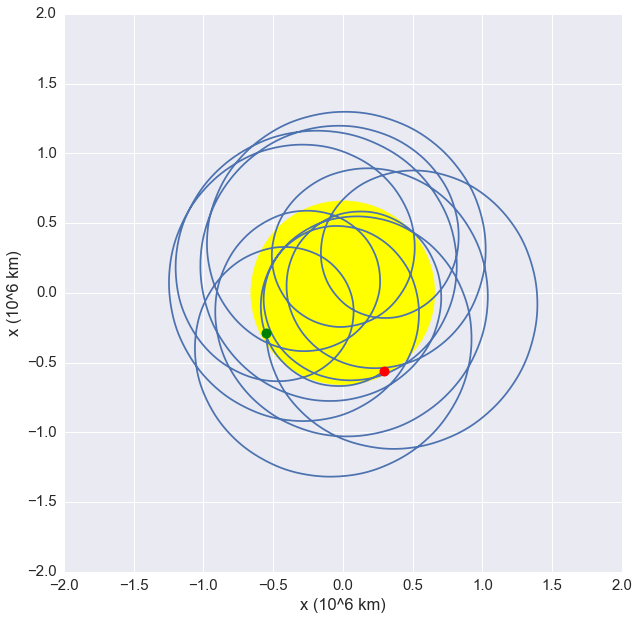

In [18]:
# Duration similar to that from lecture notes: (which is wrong)
# using m1*r1=m2*r2, and r_center=sum(mi*ri)/m_tot to calculate position(x,y coord) of solar system
sns.set(font_scale=1.5)
a.include_post_newtonian=True
M=[]
for i in range(0,len(a.mass)):
    M.append(np.longdouble(a.mass[i])) ## storing masses of objects
tot=sum(M)

X=[]
Y=[]
for i in range(0,(365*86400)*100*10//(86400*7)//8+520):  ## about 100 years duration
    tmpx=[]
    tmpy=[]
    for j in range(0,len(M)):
        tmpx.append(np.longdouble(a.get_planet_xy(i*86400*7)[0][j])*M[j]) # 7 days interval
        tmpy.append(np.longdouble(a.get_planet_xy(i*86400*7)[1][j])*M[j])
    X.append(sum(tmpx)/tot)
    Y.append(sum(tmpy)/tot)
fig=pt.figure(figsize=(10,10))
ax=fig.gca()
pt.plot(np.asarray(X)/10**9,np.asarray(Y)/10**9)
pt.plot(X[0]/10**9,Y[0]/10**9,'o',color='green',markersize=10)
pt.plot(X[-1]/10**9,Y[-1]/10**9,'o',color='red',markersize=10)
pt.xlabel('x (10^6 km)')
pt.ylabel('x (10^6 km)')
pt.xlim(-2,2)
pt.ylim(-2,2)
c=pt.Circle((0,0),0.66,color='yellow')
ax.add_artist(c)
pt.show()

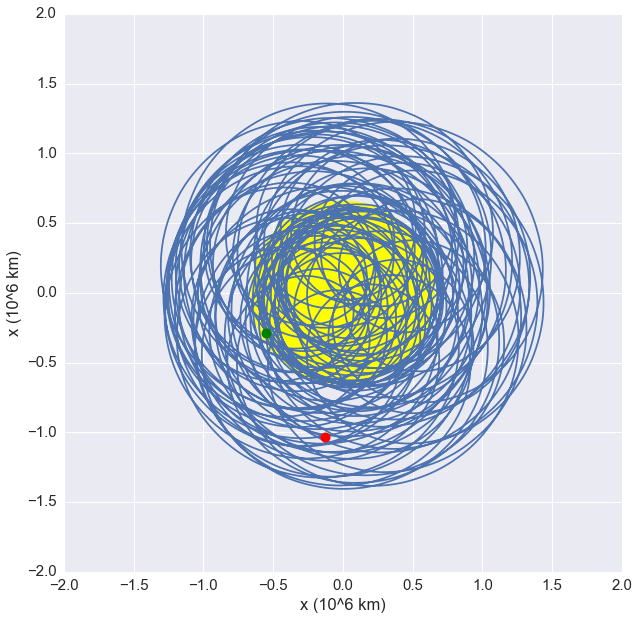

In [19]:
# 10 Centuries duration:  
a.include_post_newtonian=True
M=[]
for i in range(0,len(a.mass)):
    M.append(np.longdouble(a.mass[i]))
tot=sum(M)

X=[]
Y=[]

for i in range(0,365*86400*100*10//(86400*7)):
    tmpx=[]
    tmpy=[]
    for j in range(0,len(M)):
        tmpx.append(np.longdouble(a.get_planet_xy(i*86400*7)[0][j])*M[j])
        tmpy.append(np.longdouble(a.get_planet_xy(i*86400*7)[1][j])*M[j])
    X.append(sum(tmpx)/tot)
    Y.append(sum(tmpy)/tot)
fig=pt.figure(figsize=(10,10))
ax=fig.gca()
pt.plot(np.asarray(X)/10**9,np.asarray(Y)/10**9)
pt.plot(X[0]/10**9,Y[0]/10**9,'o',color='green',markersize=10)
pt.plot(X[-1]/10**9,Y[-1]/10**9,'o',color='red',markersize=10)
pt.xlabel('x (10^6 km)')
pt.ylabel('x (10^6 km)')
pt.xlim(-2,2)
pt.ylim(-2,2)
c=pt.Circle((0,0),0.66,color='yellow')
ax.add_artist(c)
pt.show()

<font size=4>Time spent: Problem 1: 30 minutes. Problem 2: 2 hours. Collaboration: completed on my own. Reference: Stackoverflow on np.longdouble().<font>